# Ising Model Simulation

This program runs simulations for the following lattices:
- Square lattice (4 neighbors per dipole)
- Triangular lattice (6 neighbors per dipole)
- Hexagonal lattice (3 neighbors per dipole)
- Diluted square lattice (similar to the square lattice, but random bonds are broken)
- 1D lattice (2 neighbors per dipole)
- Erdos-Renyi lattice (each dipole has probability p of connecting to another node in the lattice)

Each dipole in the lattice will be a Node object. Below the definition of the Node class, 
a BaseLattice class is defined to provide the majority of the methods used when running the
simulation. Each lattice will inherit from the BaseLattice class, and they will define the
find_neighbors() method specific to the lattice. Using an object oriented approach makes it
a lot easier to create new lattices since only the find_neighbors() method has to be changed.
In addition, some lattice classes have the flexability to modify any of the BaseLattice methods
if needed.

Even though each lattice is fundamentally different in terms of node arrangements, the
simulation I built ultimately maps each lattice onto a 2D array. The key difference between
the different lattices is how the neighbors of each node are calculated. From a graph theory
perspective, the 2D array and the original lattice are isomorphic to each other.

One cool feature I implemented is you can see a progress bar of the simulation as it runs!
This is by far the most accurate way to know how much longer it will be until it finishes.

In [1]:
# import the necessary libraries
import math
import matplotlib.pyplot as plt
import random
import time
from time import sleep
from IPython.display import clear_output  # allows me to clear the output of a cell

In [2]:
class Node:
    """ This class will act as a node for an Ising lattice. Each dipole in the lattice
        will be an object of this class.
    """

    def __init__(self, spin: int, index: tuple):
        self.spin = spin     # the spin (-1 or 1)
        self.index = index   # the position index in the lattice as (x, y)
        self.neighbors = []  # its neighbors (Node objects)

    def __str__(self):
        """ Print the info for a node whenever the print() function is used. 
            It prints the position of the node in the lattice, its spin, 
            and all of its neighbors. This is Mainly for debugging.
        """
        neighbors = ''  # concatenate the position indices for each neighbor
        for neighbor in self.neighbors:
            neighbors += str(neighbor.index)
        return "Node {} has spin {:<2} and neighbors [{}]".format(self.index, self.spin, neighbors)

    def add_neighbor(self, other):
        """ Add the node 'other' (of type Node) into the current node's neighbors"""
        self.neighbors.append(other)

    def flip_spin(self):
        """ Flip the spin of a node """
        self.spin *= -1

    def deltaE(self, J=1, mu=1, B=0):
        """ Calculate the change in energy for a node by adding the
            spins of each neighboring node. Can also include the
            external field factor if B is provided.

        Args:
            J:  The strength of the coupling
            mu: The magnetic susceptibility to external fields
            B:  The strength of the external field

        Returns:
            The change in energy
        """
        # get the term from the external field
        field = 2 * mu * B * self.spin
        # sum up the neighbor nodes
        total_mag = 0
        for neighbor in self.neighbors:
            total_mag += neighbor.spin
        total_mag *= 2 * J * self.spin

        return field + total_mag
    
class BaseLattice:
    """ The base class for a lattice. Other lattices will inherit from this.
        The subclasses MUST call initialize() at the very end of __init__, and
        each subclass must implement the find_neighbors() method!
    """

    def __init__(self, size: int):
        self.row_size = size  # the number of rows
        self.col_size = size  # the number of columns
        self.lattice = None   # a 2D list. Created when initialize() is called in subclass
        self.name = 'BASE CLASS'  # The name. Should be redefined in subclass
    
    def __str__(self):
        """ Prints the squares of the lattice graphically. Also prints the name of
            the lattice and its dimensions. Called when print() is used """
        self.print_lattice()
        return "Lattice type: {}, Lattice size: {} x {}".format(self.name, self.row_size, self.col_size)

    def initialize(self):
        """ Initialize the lattice with a random spin for each dipole """
        s = []  # temporary lattice
        for i in range(self.row_size):  # create each row for the lattice
            row = []
            for j in range(self.col_size):  # fill up each row with a Node object
                if random.randint(0, 1) == 1:
                    row.append(Node(1, (i, j)))
                else:
                    row.append(Node(-1, (i, j)))
            s.append(row)
        self.lattice = s  # set the lattice class vlariable
        self.find_neighbors()  # find the neighbors for each node in the lattice
        return s
    
    def remagnetize(self):
        """ Re-randomize the lattice with new random spins """
        for row in self.lattice:
            for node in row:
                # set a node's spin randomly
                if random.randint(0, 1) == 1:
                    node.spin = 1
                else:
                    node.spin = -1

    def find_neighbors(self):
        """ Find the neighbors of each node. Each sub class should define
            this method.
        """
        raise NotImplementedError("Subclass should overwrite this method!")

    def print_all_nodes(self):
        """ print information about each node in the lattice. Mainly a 
            debugging tool.
        """
        for row in self.lattice:
            for node in row:
                print(node)

    def print_lattice(self):
        """ Prints the current 2D lattice.
            Black square = up, white square = down
        """
        print('')
        for row in self.lattice:
            for col in row:
                if col.spin == 1:
                    print("⬛️", end='')
                else:
                    print("⬜️", end='')
            print('')

    def get_total_energy(self, J=1, mu=1, B=0):
        """ Return the total energy in the presence of an external magnetic field.
            Overall, go through each edge in the lattice, and compute the energy 
            between two nodes if the edge has not been used before. In the end, 
            each node in the lattice will be visited exactly once.

        Args:
            J:  The strength of the coupling
            mu: The magnetic susceptibility to external fields
            B:  The strength of the external field

        Returns:
            The total energy
        """
        energy = 0
        visited = set()  # keep track of which nodes have been used. A set is much faster for searches
        # go through each node in the lattice
        for row in self.lattice:
            for node in row:
                # add the energies if the edge between the nodes hasn't been visited yet
                for neighbor in node.neighbors:
                    if neighbor.index not in visited:
                        energy += -J * node.spin * neighbor.spin
                visited.add(node.index) 
                energy += -mu * B * node.spin  # add external field factor 
        return energy

    def get_total_magnetization(self):
        """ Returns the sum of all the spins in the lattice """
        total = 0
        for row in self.lattice:
            for node in row:
                total += node.spin
        return total

    def run_simulation(self, T, num_steps=None, J=1, mu=1, B=0, print_progress=False):
        """ The main Monte Carlo sumulation for the Ising model. I recommend 
            that print_progress is set to True since it will print a progress
            bar. Especially for large lattices or large number of steps, this
            is very helpful to know how much time remains before it completes.
            The drawback is it does slow things down a little, but it is well
            worth it in the end.
            
        Args:
            T: The temperature
            num_steps: Used to force the total number of iterations to do
            J:  The strength of the coupling
            mu: The magnetic susceptibility to external fields
            B:  The strength of the external field
            print_progress: if set to True, will print the progress of the simulation
                            as a progress bar.
            
        Returns:
            a tuple of energy and magnetization lists as (<list of energy>, <list of mag>)
        """
        # use the provided num_steps value, or use a default value
        if num_steps is None:
            num_steps = 10000 * (self.row_size * self.col_size)

        # keep track of the energy and magnetization
        energy = [self.get_total_energy()]
        magnetization = [self.get_total_magnetization()]

        # to be used if print_progress is enabled
        start_time = time.time()
        checkpoints = set()  # faster than a list when doing a search
        checkpoint_count = 0
        for i in range(50):
            checkpoints.add(num_steps * i / 50)

        # main simulation loop
        for iteration in range(num_steps):
            # print the progress if print_progress is set
            if print_progress and iteration in checkpoints:
                print("     " * 11, end='\r')  # "\r" moves the pointer to beginning of line
                print("Progress: [{:<50}]".format('#' * checkpoint_count), end='')
                checkpoint_count += 1

            # find a random node
            row = random.randint(0, self.row_size - 1)
            col = random.randint(0, self.col_size - 1)
            cur_node = self.lattice[row][col]  # the randomly chosen node

            dE = cur_node.deltaE(J, mu, B)

            # accept if dE is negative or with a given probability
            if (dE <= 0) or (random.random() < math.exp(-dE/T)):
                # flip the spin of the node
                cur_node.flip_spin()
                # add values into the energy and mag lists
                energy.append(energy[-1] + dE)
                magnetization.append(magnetization[-1] + 2 * cur_node.spin)
            else:
                # only add the previous values in the energy and mag lists,
                # will not flip the spin of the current node.
                energy.append(energy[-1])
                magnetization.append(magnetization[-1])

        # print the progress if print_progress is set
        if print_progress:
            print("     " * 10, end='\r')
            print("Progress: [{}] {} s".format('#' * 50, round(time.time() - start_time), 5))

        return energy, magnetization
                
def calc_heat_capacity(t_list, meanE):
    """ Calculates the heat capacity. This overall will find the 
        slope between two temperatures, and slope is the heat 
        capacity. Given temperatures t1 and t2, the heat capacity
        will be located in the middle of t1 and t2.
        
    Args:
        t_list: A list of temperatures
        meanE:  A list of the average energies at each temperature in t_list
        
    Returns:
        new_t:  A list of temeratures for the heat capacity
        heat_capacity: A list of heat capacities at temperatures in new_t
    """
    new_t = []  # store the times that split times in t_list
    heat_capacity = []  # store the heat capacity
    for i in range(len(t_list) - 1):
        # heat capacity = rise over run; change in E divided by change in T
        heat_capacity.append((meanE[i + 1] - meanE[i]) / (t_list[i + 1] - t_list[i]))
        new_t.append(((t_list[i + 1] - t_list[i]) / 2) + t_list[i])
    return new_t, heat_capacity
                
def simulate_and_plot(lattice, t_start, t_end, t_step, num_iterations=None):
    """ Runs the monte carlo simulation for a range of temperatures
        and plots the results.
        
    Args:
        lattice: An object of a lattice class, such as SquareLattice.
        t_start: The starting temperature
        t_end:   The ending temperature (not inclusive)
        t_step:  The (positive) step interval for the temperature
        num_iterations: The number of iterations to do for each temperature.
                        If it is None, use the default number of iterations
                        defined in the run_simulation method.
    """
    assert t_step > 0 # make sure t_step is positive
    
    # keep track of the average magnetization and average energy per run
    meanE = []
    meanM = []

    # get a list of times to run the simulation using the time parameters
    t_list = []
    T = t_start
    while T < t_end:
        t_list.append(T)
        T += t_step

    # run the simulation for each T in the list of temperatures
    for i in range(len(t_list)):
        T = t_list[i]
        
        # stuff to print a progress bar
        print("     " * 5, end='\r')
        print("{}/{}".format(i + 1, len(t_list)))
        
        # randomize the spin in the lattice each iteration
        lattice.remagnetize()
        
        # the simulation call itself
        if num_iterations is not None:
            energy, magnetization = lattice.run_simulation(T, num_iterations, print_progress=True)
        else:
            energy, magnetization = lattice.run_simulation(T, print_progress=True)
            
        # reset the output of whatever was printed after each iteration
        clear_output(wait=True)  
        
        # add the averaged results of the simulation to the meanE and meanM lists
        meanE.append(sum(energy) / len(energy))
        meanM.append(sum(magnetization) / len(magnetization))

    # progress bar stuff
    print('{}/{}'.format(len(t_list), len(t_list)))

    # divide each element in the two arrays by the number of nodes in the lattice
    for i in range(len(meanE)):
        meanE[i] /= square.row_size * square.col_size
        meanM[i] /= square.row_size * square.col_size
    
    # get the heat hapacity
    heat_cap_t, heat_cap = calc_heat_capacity(t_list, meanE)

    # plot average energy
    plt.figure(0)
    plt.plot(t_list, meanE, 'o')
    plt.title("Average Energy vs. Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("$E/N_{sites}$")
    
    # plot the heat capacity
    plt.figure(1)
    plt.plot(heat_cap_t, heat_cap, 'o')
    plt.title("Heat capacity vs. Temerature")
    plt.xlabel("Temperature")
    plt.ylabel("Heat capacity")

    # plot average magnetization
    plt.figure(2)
    plt.plot(t_list, meanM, 'o')
    plt.title("Average Magnetization vs. Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("$M/N_{sites}$")

    plt.show()
    

## Square lattice

This is the basic lattice covered in a previous homework assignment. 
Each node in the lattice has 4 neighbors. 

30/30


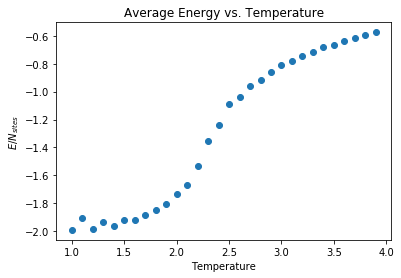

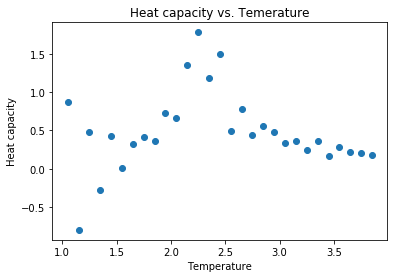

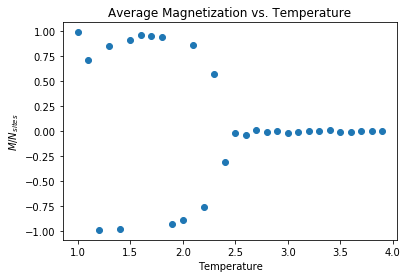


⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️
⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️
⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️
⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️
⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️
⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬜️
⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️
⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️
⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️
⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️
⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️
⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️
⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️
⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️
⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️
⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️
⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️
⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️
Lattice type: square, Lattice size: 20 x 20


In [3]:
class SquareLattice(BaseLattice):
    """ Inherits from BaseLattice """
    def __init__(self, size: int):
        super().__init__(size)  # include the variables from the parent class
        self.name = 'square'
        self.initialize()  # initialize the lattice

    def find_neighbors(self):
        """ Find the neighbors for a square lattice. Includes
            periodic boundary conditions.
        """
        for i in range(self.row_size):
            for j in range(self.col_size):
                node = self.lattice[i][j]
                node.add_neighbor(self.lattice[i-1][j])  # top
                node.add_neighbor(self.lattice[(i+1) % self.row_size][j])  # bottom
                node.add_neighbor(self.lattice[i][j-1])  # left
                node.add_neighbor(self.lattice[i][(j+1) % self.col_size])  # right

square = SquareLattice(20)
simulate_and_plot(square, t_start=1, t_end=4, t_step=0.1, num_iterations=1000000)
print(square)

## Triangular lattice

This is very similar to the square lattice. The difference is the triangular lattice
adds on two diagonal edges for each node.

30/30


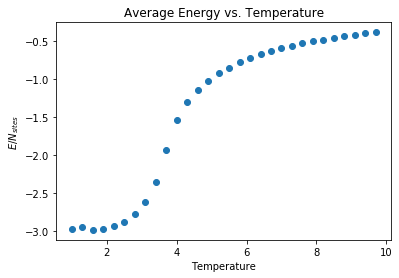

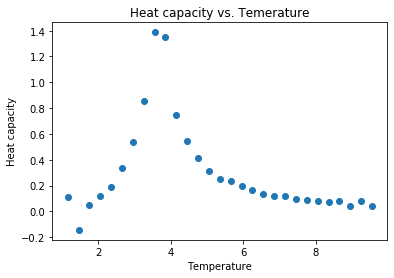

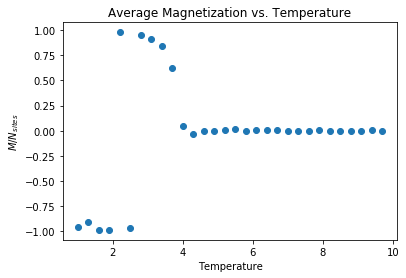


⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️
⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️
⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️
⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️
⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️
⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬜️
⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️
⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️
⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️
⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️
⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️
⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️
⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️
⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️
⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️
⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬛️
⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️
⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️
⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️
⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️
Lattice type: triangle, Lattice size: 20 x 20


In [19]:
class TriangularLattice(BaseLattice):
    def __init__(self, size: int):
        """ Inherits from BaseLattice """
        super().__init__(size)  # include the variables from the parent class
        self.name = 'triangle'
        self.initialize()  # initialize the lattice

    def find_neighbors(self):
        """ Find the neighbors for a triangular lattice. Includes
            periodic boundary conditions.
        """
        for i in range(self.row_size):
            for j in range(self.col_size):
                node = self.lattice[i][j]
                node.add_neighbor(self.lattice[i-1][j])  # top
                node.add_neighbor(self.lattice[(i+1) % self.row_size][j])  # bottom
                node.add_neighbor(self.lattice[i][j-1])  # left
                node.add_neighbor(self.lattice[i][(j+1) % self.col_size])  # right
                node.add_neighbor(self.lattice[i-1][(j+1) % self.col_size]) # northeast edge
                node.add_neighbor(self.lattice[(i+1) % self.row_size][j-1]) # southwest edge

triangle = TriangularLattice(20)
#triangle.print_all_nodes()  # <-- uncomment to make sure the neighbors are correct (debug)
simulate_and_plot(triangle, t_start=1, t_end=10, t_step=0.3, num_iterations=1000000)
print(triangle)

## Hexagonal lattice

The lattice, also called a honeycomb lattice, looks like a bunch of hexagons. Each node has 3 neighbors.

30/30


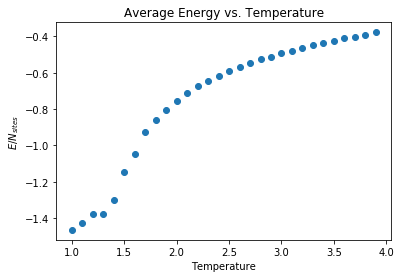

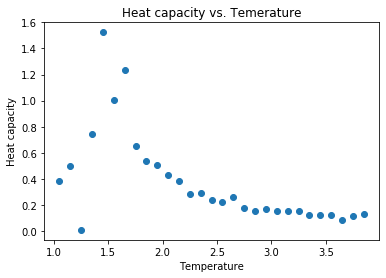

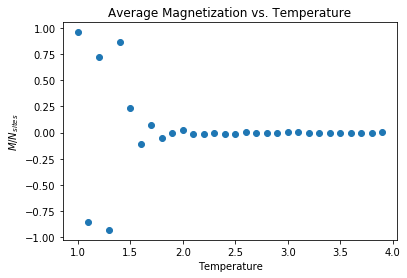


⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️
⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️
⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️
⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️
⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️
⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️
⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️
⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️
⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️
⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️
⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️
⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️
⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬜️
⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️
⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️
⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬜️
⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️
⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️
Lattice type: hexagonal, Lattice size: 20 x 20


In [5]:
class HexagonalLattice(BaseLattice):
    """ Inherits from BaseLattice """
    def __init__(self, size: int):
        super().__init__(size)  # include the variables from the parent class
        self.row_size = size    # override the number of rows from the base class
        
        # For this lattice to work, the number of columns must be even.
        # This means the number of columns may not match the number of rows by 1.
        if size % 2 == 1:
            self.col_size = size + 1  
        else:
            self.col_size = size
        self.name = 'hexagonal'
        self.initialize()

    def find_neighbors(self):
        """ Find the neighbors for a hexagonal lattice. Each node in
            a row will be connected to the node to its left and to 
            its right. However, only the nodes at an even column will
            have a top neighbor, and only the odd columns will have
            a bottom neighbor. This ensures each node has exxactly 3
            neighbors. Includes periodic boundary conditions.
        """
        for i in range(self.row_size):
            for j in range(self.col_size):
                node = self.lattice[i][j]
                
                node.add_neighbor(self.lattice[i][j-1])  # left
                node.add_neighbor(self.lattice[i][(j+1) % self.col_size])  # right
                
                # each will have either a top neighbor OR a bottom neighbor
                if j % 2 == 0:
                    # even j indices have a top neighbor to the right
                    node.add_neighbor(self.lattice[i-1][(j+1) % self.col_size])
                else:
                    # odd indices have a bottom neighbor to the left
                    node.add_neighbor(self.lattice[(i+1) % self.row_size][j-1])

hexagon = HexagonalLattice(20)
simulate_and_plot(hexagon, t_start=1, t_end=4, t_step=0.1, num_iterations=1000000)
print(hexagon)

## Diluted square lattice

This uses the square lattice class, but a fraction of the bonds are broken at random

30/30


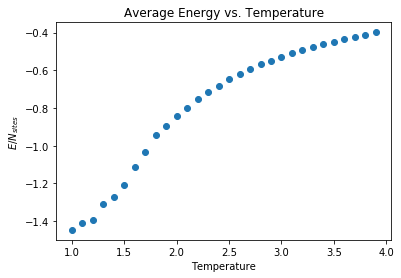

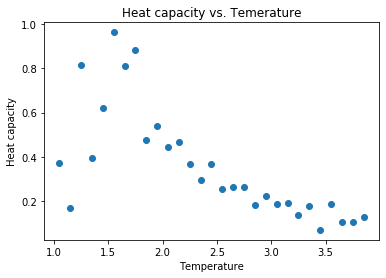

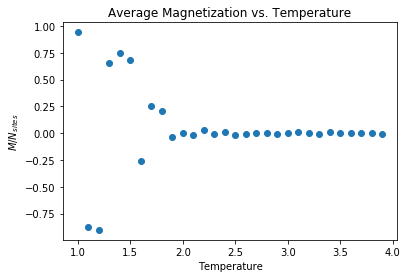


⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬛️
⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️
⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️
⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️
⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️
⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️
⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️
⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️
⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️
⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️
⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️
⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️
⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️
⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️
⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️
⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️
⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️
⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️
Lattice type: diluted square, Lattice size: 20 x 20


In [6]:
class DiluteSquareLattice(SquareLattice):
    """ This inherits from the SquareLattice class, so it will
        inherit the find_neighbors() method from it. For the diluted
        feature to work, a dilute() method has to be implemented
        to randomly remove the existing bonds between nodes. 
        
        IMPORTANT: call the dilute method BEFORE running the simulation.
                   Failure to do so will cause none of the bonds to be
                   removed!
    """
    def __init__(self, size: int):
        super().__init__(size)
        self.name = 'diluted square'
        self.initialize()
        
    def dilute(self, bonds_to_remove: int = 0):
        """ This method randomly removes a fraction of the bonds. If you
            want to remove a fraction of the total bonds, pre-calculate
            the fractional bonds before passing it to this method.
            
            IMPORTANT: call the dilute method BEFORE running the simulation.
                       Failure to do so will cause none of the bonds to be
                       removed!
        Args:
            bonds_to_remove: The number of bonds to remove
        
        Returns:
            A list of the bonds removed
        """
        num_bonds = 4 * self.row_size * self.col_size # total number of bonds in lattice
        removed_bonds = []  # keep track of the bonds that were removed
        
        # if bonds_to_remove is more than the size of the lattice, remove everything.
        # this prevents an infinite while loop from happening. 
        if bonds_to_remove > self.row_size * self.col_size:
            bonds_to_remove = self.row_size * self.col_size
        
        while bonds_to_remove > 0:
            # find a random node
            row = random.randint(0, self.row_size - 1)
            col = random.randint(0, self.col_size - 1)
            node = self.lattice[row][col]
            
            # pick a random neighbor node. If there are no neighbors left, 
            # pick a different node.
            num_neighbors = len(node.neighbors)
            if num_neighbors > 0:
                neighbor = node.neighbors[random.randint(0, num_neighbors - 1)]

                # remove neighbor from the node, and remove node from neighbor's neighbor
                node.neighbors.remove(neighbor)
                neighbor.neighbors.remove(node)
                removed_bonds.append((node.index, neighbor.index))
                
                bonds_to_remove -= 1
        return removed_bonds

# uncomment the lines below to see the neighbors for each node.    

diluted_square = DiluteSquareLattice(20)
#print("before\n")
#diluted_square.print_all_nodes()

fraction = int(diluted_square.row_size**2 * 0.5) # calculate the number of bonds to remove 50% of all the bonds
removed_bonds = diluted_square.dilute(fraction)  # remove 50% of the bonds

#print("after\n")
#diluted_square.print_all_nodes()

simulate_and_plot(diluted_square, t_start=1, t_end=4, t_step=0.1, num_iterations=1000000)
print(diluted_square)

for bond in removed_bonds:
    node1, node2 = bond
    #print("Removing bond between {} <--> {}".format(node1, node2))  # <-- uncomment to see the removed neighbors

## 1D lattice

This implements a 1D lattice. Instead of using one long array to store the
nodes, I used a 2D list, and the neighbor pairs snake around the lattice
such that each node has only two neighbors. This "verifies" the exact solution
for a 1D lattice where the average energy should be of the form tanh$(\frac{1}{T})$.

30/30


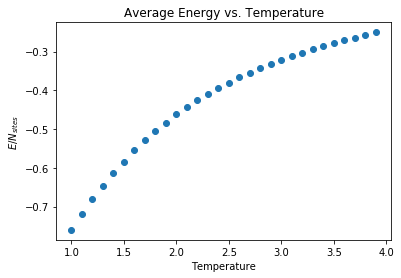

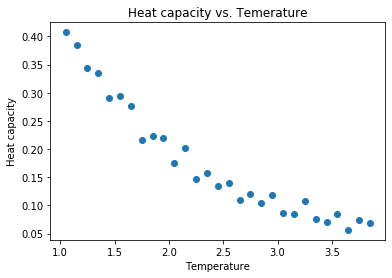

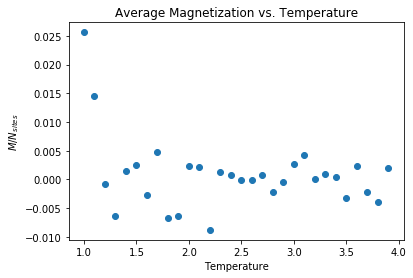


⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️
⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️
⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️
⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️
⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️
⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️
⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️
⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️
⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️
⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️
⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️
⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️
⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️
⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️
⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️
⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️
⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️
⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️
⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬛️
Lattice type: 1D, Lattice size: 20 x 20


In [7]:
class oneDLattice(BaseLattice):
    def __init__(self, size: int):
        super().__init__(size)
        self.name = '1D'
        self.initialize()

    def find_neighbors(self):
        """ Find the neighbors for a 1D lattice. Includes
            periodic boundary conditions. Overall, the top 
            row will go from left to right, then the second
            row will go right to left. This process snakes
            around the lattice so that each node has exactly
            two neighbors.
        """
        # step 1: add the left and right neighbors
        for i in range(self.row_size):
            for j in range(self.col_size):
                node = self.lattice[i][j]
                
                # add the left neighbor if the column is not the far left
                if j > 0:
                    node.add_neighbor(self.lattice[i][j-1]) 
                    
                # add the right neighbor if the column is not the far right
                if j < self.col_size - 1:
                    node.add_neighbor(self.lattice[i][(j+1) % self.col_size])
                    
        # check if the number of rows is even or odd
        rows_are_even = self.row_size % 2 == 0
        
        # step 2: add the top and bottom neighbors
        for i in range(self.row_size):
            
            # add the top neighbors
            if i == 0:  # if its the top row (only the far left node on top)
                if rows_are_even:  # the total number of rows is even, 
                    self.lattice[0][0].add_neighbor(self.lattice[-1][0])  # add bottom left node
                else:
                    self.lattice[0][0].add_neighbor(self.lattice[-1][-1]) # add bottom right node
            else:
                # all even rows will have a top edge on the far left
                if i % 2 == 0: # row is even
                    self.lattice[i][0].add_neighbor(self.lattice[i-1][0]) 
                # all odd rows will have a top edge on the far right
                else:
                    self.lattice[i][-1].add_neighbor(self.lattice[i-1][-1]) 
                    
            # add the bottom neighbors
            if i == self.row_size - 1:  
                # the last node will always connect to the top left node
                if rows_are_even:
                    self.lattice[i][0].add_neighbor(self.lattice[0][0])
                else:
                    self.lattice[i][-1].add_neighbor(self.lattice[0][0])
            else:
                # all even rows will have a bottom edge on the right
                if i % 2 == 0: # row is even
                    self.lattice[i][-1].add_neighbor(self.lattice[i+1][-1])
                # all odd rows will have a bottom edge on the left
                else:
                    self.lattice[i][0].add_neighbor(self.lattice[i+1][0])
            
line = oneDLattice(20)
simulate_and_plot(line, t_start=1, t_end=4, t_step=0.1, num_iterations=1000000)
print(line)

## Erdos-Renyi random lattice

Unlike the previous lattices, each node in this lattice does not have
a predefined number of neighbor nodes. Instead, there is a probability p
that an edge is connected between one node and another for every possible edge
in the graph. 

In [8]:
class ErdosRenyiLattice(BaseLattice):
    def __init__(self, size: int, probability):
        super().__init__(size)
        self.name = 'Erdos-Renyi'
        self.probability = probability  # add edge if random.random() < probability
        self.initialize()

    def find_neighbors(self):
        """ randomly assign an edge with probability p for
            each node in the graph. Includes
            periodic boundary conditions.
        """
        # go through each node in the lattice
        for i in range(self.row_size):
            for j in range(self.col_size):
                node = self.lattice[i][j]
                
                # go through each node in the lattice again to find a potential neighbor
                for row in self.lattice:
                    for next_node in row:
                        are_different = node != next_node  # make sure the node is not itself
                        should_add = random.random() < self.probability  # calculate the probability
                        not_neighbors = node not in next_node.neighbors  # make sure edge doesn't already exist
                        if are_different and should_add and not_neighbors:
                            # add each other as neighbors
                            node.add_neighbor(next_node)
                            next_node.add_neighbor(node)


### Run the Erdos-Renyi simulation with probability p = 0.001

On average I would expect 400*0.001 = 0.4 neighbors per node for a 20x20 grid

30/30


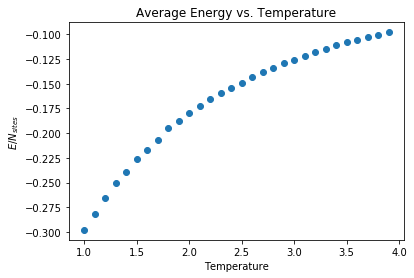

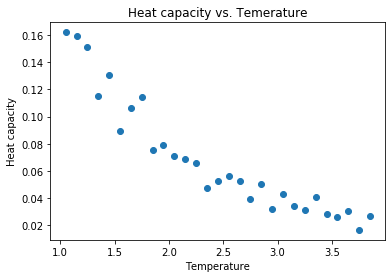

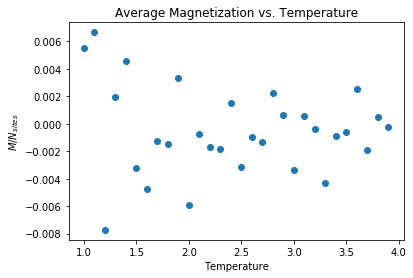


⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️
⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️
⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬜️
⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️
⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️
⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️
⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬜️
⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️
⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️
⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️
⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️
⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬛️
⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️
⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️
⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️
⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️
⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️
⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️
⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️
⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️
Lattice type: Erdos-Renyi, Lattice size: 20 x 20


In [9]:
er_lattice = ErdosRenyiLattice(size=20, probability=0.001)
simulate_and_plot(er_lattice, t_start=1, t_end=4, t_step=0.1, num_iterations=500000)
print(er_lattice)

### Now run the Erdos-Renyi simulation with probability p = 0.0025

On average I would expect 400*0.0025 = 1 neighbor per node for a 20x20 grid.

30/30


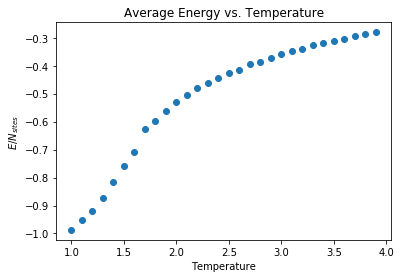

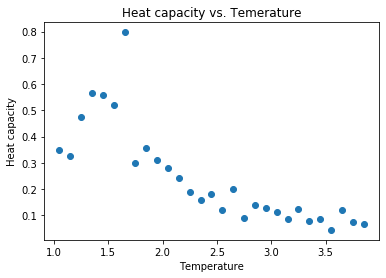

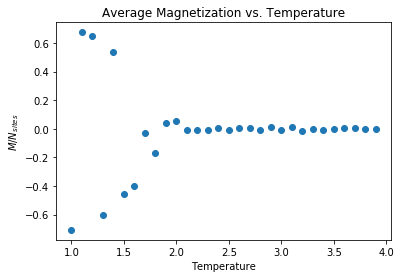


⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️
⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️
⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️
⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️
⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬜️
⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️
⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️
⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️
⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️
⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️
⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️
⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️
⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️
⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️
⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️
⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️
⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️
⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️
⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️
⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️
Lattice type: Erdos-Renyi, Lattice size: 20 x 20


In [15]:
er_lattice = ErdosRenyiLattice(size=20, probability=0.0025)
simulate_and_plot(er_lattice, t_start=1, t_end=4, t_step=0.1, num_iterations=500000)
print(er_lattice)

### Now run the Erdos-Renyi simulation with probability p = 0.01

On average I would expect 400*0.01 = 4 neighbors per node for a 20x20 grid.

36/36


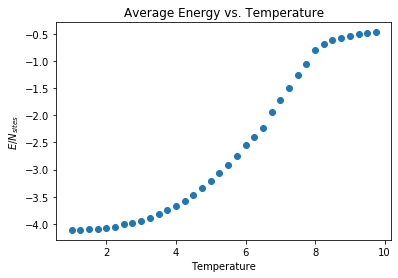

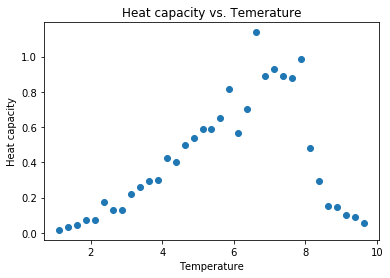

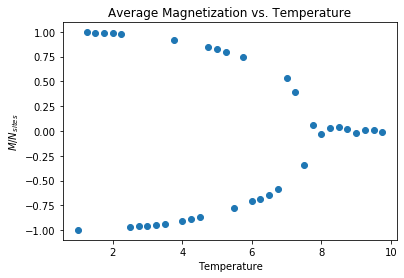


⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️
⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬜️
⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬛️⬜️⬜️
⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️
⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️
⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️
⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️
⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️
⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️
⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬛️
⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️
⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️
⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️
⬛️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬛️
⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬜️⬛️
⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬜️
⬜️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️⬜️⬛️
⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️
⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬜️
⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️
Lattice type: Erdos-Renyi, Lattice size: 20 x 20


In [14]:
er_lattice = ErdosRenyiLattice(size=20, probability=0.01)
simulate_and_plot(er_lattice, t_start=1, t_end=10, t_step=0.25, num_iterations=500000)
print(er_lattice)

### Now run the Erdos-Renyi simulation with probability p = 0.025

On average I would expect 400*0.025 = 10 neighbors per node for a 20x20 grid.
After this, where p > 0.025, there are no significant differences since each
node has so many neighbors.

30/30


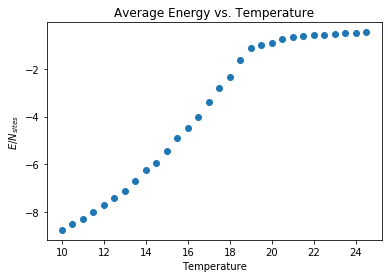

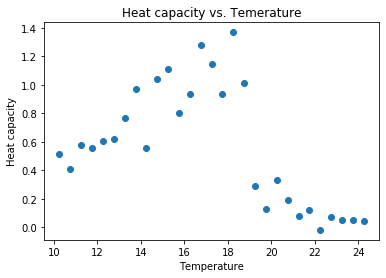

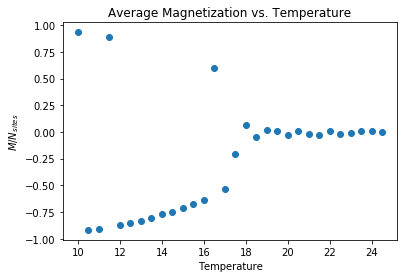


⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️
⬛️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬛️
⬜️⬛️⬜️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬜️
⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬜️⬜️
⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬜️
⬛️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️
⬜️⬛️⬛️⬛️⬛️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️
⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬜️
⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬜️⬛️
⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬜️
⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬛️⬜️⬛️
⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬛️⬛️⬜️⬜️⬛️
⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬜️
⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬜️
⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️
⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬜️⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬜️⬛️⬛️⬛️⬜️
⬜️⬜️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬜️⬛️⬜️⬛️⬜️⬜️⬛️⬜️⬜️⬛️
⬜️⬜️⬜️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬛️⬛️
⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬛️⬛️⬛️⬛️⬜️⬜️⬜️⬜️⬛️⬛️⬜️⬛️
⬜️⬜️⬛️⬛️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬜️⬛️⬜️⬛️⬛️⬛️⬛️
Lattice type: Erdos-Renyi, Lattice size: 20 x 20


In [27]:
er_lattice = ErdosRenyiLattice(size=20, probability=0.025)
simulate_and_plot(er_lattice, t_start=10, t_end=25, t_step=0.5, num_iterations=500000)
print(er_lattice)